# Peak fitting example

Charles Le Losq, May 2017; Updated January 2024, April 2025

In the new version, we showcase the use of the `fit_peaks` function and then show also how you can solve the problem with Turing.jl and JuMP too. Running the notebook entirely thus requires you to have those installed, but if you want to stop at the `fit_peaks` function, you can skip the cells related to Turing.jl and JuMP!

## Generating data

We generate three peaks using Spectra's functions:

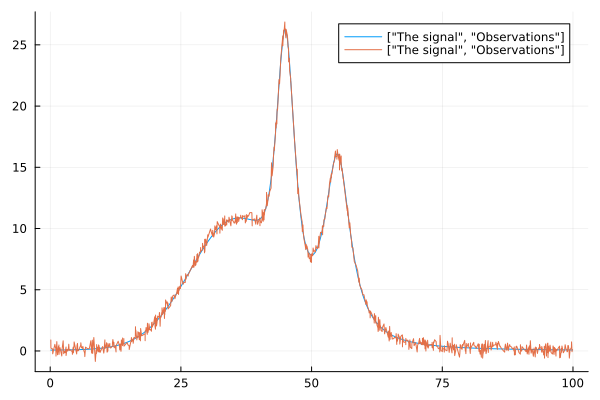

In [2]:
# using Spectra and Plots for plotting and peak fitting
using Plots, Spectra

# the X axis, at random values
x_fit = sort(rand(1000)*100)

# the perfect signal
y_fit_perfect = (gaussian(x_fit, [10.0, 35.0, 10.0]) 
+ lorentzian(x_fit, [15.0, 55.0, 3.0]) 
+ pseudovoigt(x_fit, [20.0, 45.0, 2.0, 0.4]))

# real world = noise
noise = randn(length(x_fit))*0.3

# our observation
y_fit = y_fit_perfect + noise

p1 = plot(x_fit, [y_fit_perfect, y_fit], labels= ["The signal", "Observations"])
display(p1)

## Peak fitting

We can use `Spectra.fit_peaks()` to fit the signal, given some prior uncertainties on the peak parameters and bounds. Everything is provided in peaks_info below. We also use the Optim.jl backend, with LBFGS and automatic differentiation.

In [3]:
peaks_info = [
    # (type, prior_params, prior_uncertainties, lower_bounds, upper_bounds)
    (:gaussian, [10.5, 30.0, 3.0], [5.0, 10.0, 5.0], [0., 0., 0.], [Inf, Inf, 50.]),
    (:lorentzian, [23.5, 55.0, 3.0], [5.0, 10., 5.0], [0., 0., 0.], [100., 100., 50.]),
    (:pseudovoigt, [16.5, 44.0, 3.0, 0.4], [5.0, 10., 5.0, 0.05], [0., 0., 0., 0.], [100., 100., 50., 1.])
]
result = Spectra.fit_peaks(x_fit, y_fit, peaks_info, sigma=noise, backend=:Optim)

(fit = [0.07144302093211916, 0.0715054095823221, 0.07277701440551572, 0.07286166073177301, 0.07460783839308438, 0.07542392671270375, 0.07555749534655296, 0.07630144716552473, 0.0765455406478892, 0.0769543456072187  …  0.0865438347667571, 0.08618531313089728, 0.08573384222789976, 0.0854661589404623, 0.08494932490792728, 0.08403574802158337, 0.08392011765534577, 0.08359093544816704, 0.08345392673186047, 0.0832502349015004], peak_results = Any[(type = :gaussian, params = [10.016172314610522, 34.922735689711196, 10.003263207988716], errors = [0.054251900491698035, 0.11244207580248035, 0.10301038431232994]), (type = :lorentzian, params = [14.953781032534629, 54.996384112603074, 3.0160540478214037], errors = [0.0823805467861693, 0.017431830744819035, 0.02762932511017719]), (type = :pseudovoigt, params = [19.995931266238102, 45.00746974224061, 2.006626638513967, 0.3948328574754679], errors = [0.1763758048658487, 0.009784014823140286, 0.019518484374165673, 0.02925368722112295])], residuals = [

We can plot the results:

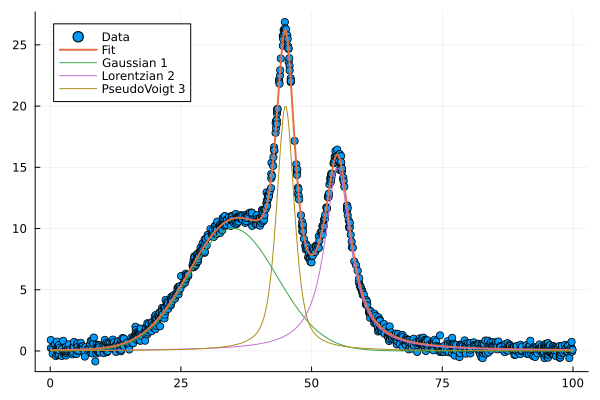

In [4]:
result.plot_fit(components=true)

Also we can print the parameters and calculated errors (using the Hessian):

In [5]:
result.print_params()

Peak 1 (gaussian):
  amplitude: 10.0162 ± 0.0543
  center: 34.9227 ± 0.1124
  width: 10.0033 ± 0.103
Peak 2 (lorentzian):
  amplitude: 14.9538 ± 0.0824
  center: 54.9964 ± 0.0174
  width: 3.0161 ± 0.0276
Peak 3 (pseudovoigt):
  amplitude: 19.9959 ± 0.1764
  center: 45.0075 ± 0.0098
  width: 2.0066 ± 0.0195
  fraction: 0.3948 ± 0.0293


If you want you can adjust the number of digits

In [6]:
result.print_params(digits=3)

Peak 1 (gaussian):
  amplitude: 10.016 ± 0.054
  center: 34.923 ± 0.112
  width: 10.003 ± 0.103
Peak 2 (lorentzian):
  amplitude: 14.954 ± 0.082
  center: 54.996 ± 0.017
  width: 3.016 ± 0.028
Peak 3 (pseudovoigt):
  amplitude: 19.996 ± 0.176
  center: 45.007 ± 0.01
  width: 2.007 ± 0.02
  fraction: 0.395 ± 0.029


## Checking errors with bootstrapping

`Spectra.bootsample` allows to bootstrap your spectrum and refit the model on data subsamples. This allows to check the errors on parameters!

Let's do that for the first peak:

In [7]:
amp_peak1 = []
pos_peak1 = []
width_peak1 = []
for i = 1:500
    x_boot, y_boot = bootsample(x_fit, y_fit)
    # Define peak information with initial parameters and uncertainties
    peaks_info = [
        (:gaussian, [10.5, 30.0, 3.0], [5.0, 10.0, 5.0], [0., 0., 0.], [Inf, Inf, 50.]),
    (:lorentzian, [23.5, 55.0, 3.0], [5.0, 10., 5.0], [0., 0., 0.], [100., 100., 50.]),
    (:pseudovoigt, [16.5, 44.0, 3.0, 0.4], [5.0, 10., 5.0, 0.05], [0., 0., 0., 0.], [100., 100., 50., 1.])
    ]

    # Perform the fit
    result = fit_peaks(vec(x_boot), vec(y_boot), peaks_info);
    
    append!(amp_peak1, result.peak_results[1][:params][1])
    append!(pos_peak1, result.peak_results[1][:params][2])
    append!(width_peak1, result.peak_results[1][:params][3])
    
end

println(std(amp_peak1))
println(std(pos_peak1))
println(std(width_peak1))

0.02960527775793615
0.06842931819974135
0.0709178188859632


## Exploring errors on parameters Using Turing.jl

The same problem can be tackled using Turing.jl and the peak shape functions from Spectra as follow. This offers another way to check that the estimated errors are good for instance.

It seems to run well but it is not fully optimized. If you have suggestions, do not hesitate!


In [12]:
# for Bayesian peak fitting example
using Turing

# Define a Bayesian model with priors
@model function bayesian_peaks(x, y)
    # Define priors based on peak_types
    # Example for a Gaussian peak
    amplitude ~ truncated(Normal(10.016, 0.5), 0.0, Inf)
    center ~ Normal(34.92, 0.5)
    width ~ truncated(Normal(10.0, 0.5), 0.0, Inf)

    μ = gaussian(x, [amplitude, center, width])
    
    # PEAK 2
    amplitude2 ~ truncated(Normal(14.9, 0.5), 0.0, Inf)
    center2 ~ Normal(55.0, 0.5)
    width2 ~ truncated(Normal(3.0, 0.5), 0.0, Inf)
    
    μ2 = lorentzian(x, [amplitude2, center2, width2])
    
    # PEAK 3
    amplitude3 ~ truncated(Normal(25.5, 0.5), 0.0, Inf)
    center3 ~ Normal(43.0, 10.0)
    width3 ~ truncated(Normal(2.0, 0.5), 0.0, Inf)
    lr ~ truncated(Normal(0.39, 0.03), 0.0, 1.0)
    
    # Calculate model prediction
    μ3 = pseudovoigt(x, [amplitude3, center3, width3, lr])
    
    # Likelihood
    σ ~ truncated(Normal(0.2, 0.03), 0.001, Inf)
    y ~ MvNormal(μ + μ2 + μ3, σ^2 * I)
end

chain = sample(bayesian_peaks(x_fit, y_fit), NUTS(), 2000, nchains=3, progress=true)

┌ Info: Found initial step size
└   ϵ = 0.00625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


Chains MCMC chain (2000×23×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 9.71 seconds
Compute duration  = 9.71 seconds
parameters        = amplitude, center, width, amplitude2, center2, width2, amplitude3, center3, width3, lr, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

   amplitude    9.9401    0.0412    0.0011   1313.3841   1683.9130    1.0001   ⋯
      center   34.7063    0.0823    0.0030    736.8277    844.9656    1.0011   ⋯
       width    9.8236    0.0792    0.0028    796.7888   1261.0565    1.0015   ⋯
  amplitude2   14.9976    0.0621    0.0015   1708.3360   1662.480